In [1]:
# Import the torch modules
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

# CIFAR-10

CIFAR-10 consists of 60,000 tiny 32 × 32 color (RGB) images, labeled with an integer corresponding to 1 of 10 classes: airplane (0), automobile (1), bird (2), cat (3), deer (4), dog (5), frog (6), horse (7), ship (8), and truck (9).

The following shows image samples from all CIFAR-10 classes

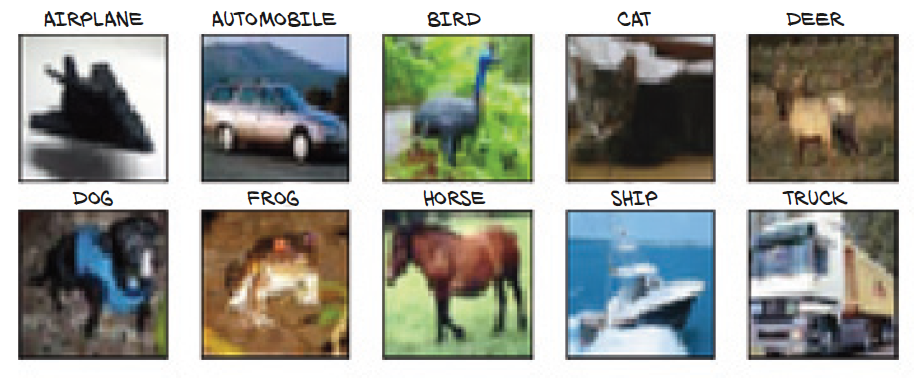

# torchvision

We will use the **torchvision** module to automatically download the dataset and load it as a collection of PyTorch tensors.


In [2]:
from torchvision import datasets

data_path = './'

# Instantiates a dataset for the training data; TorchVision downloads the data if it is not present
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
# With train=False, this gets us a dataset for the validation data, again downloading as necessary.
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 54546007.56it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


# PyTorch's Dataset class

It’s a good time to discover what being **a subclass of torch.utils.data.Dataset** means in practice.

**PyTorch Dataset**, which is an object that is required to implement two methods: **\_\_len\_\_** and **\_\_getitem\_\_**.
> - The \_\_len\_\_ method should return the number of items in the dataset;
> - The \_\_getitem\_\_ method should return the item, consisting of a sample and its corresponding label (an integer index).

**Note: a PyTorch Dataset object doesn’t necessarily hold the data, but it provides uniform access to it through __len__ and __getitem__.**

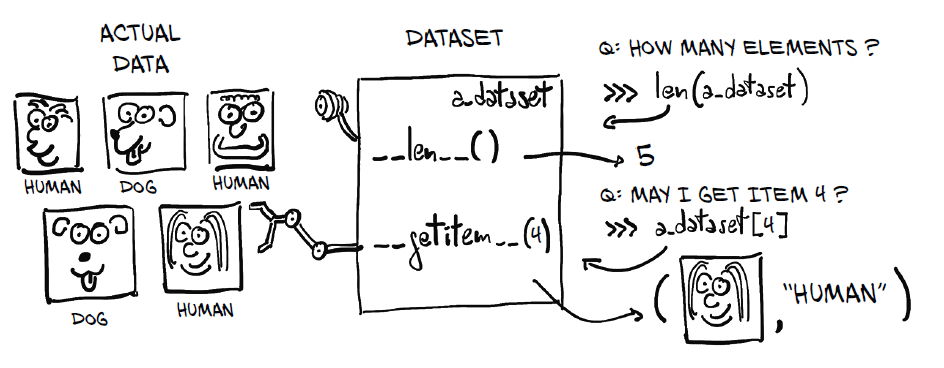

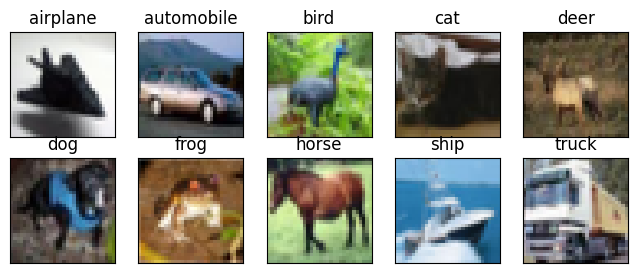

In [3]:
# class names
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

# visualize by showing some images from the dataset
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)   #Here, we get a PIL (Python Imaging Library, the PIL package) image
    plt.imshow(img)
plt.show()

# Dataset transforms

We need to convert the PIL image to a PyTorch tensor before we can do anything with it. That’s where **torchvision.transforms** comes in.

The **torchvision.transforms** module defines a set of composable, function-like objects that can be passed as an argument to a torchvision dataset such as datasets.CIFAR10(…), and that perform transformations on the data after it is loaded but before it is returned by \_\_getitem\_\_.

In [4]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

## ToTensor

Among those transforms, **ToTensor** turns NumPy arrays and PIL images to tensors. It also takes care to lay out the dimensions of the output tensor as C × H × W (channel, height, width)

img --> <PIL.Image.Image image mode=RGB size=32x32 at 0x794234C66020>
type(img) --> <class 'PIL.Image.Image'>
img.shape --> (32, 32)
label --> 1
class_names[label] --> automobile


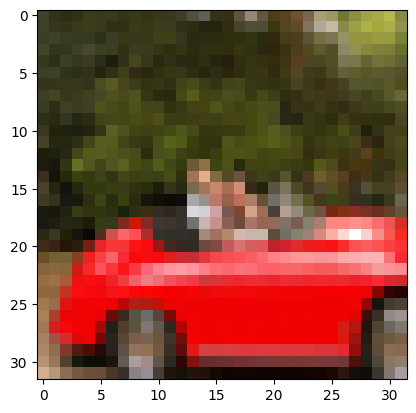


type(img_t) --> <class 'torch.Tensor'>
img_t.shape --> torch.Size([3, 32, 32])
img_t.dtype --> torch.float32


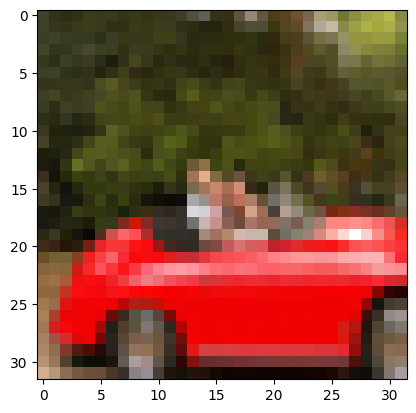

In [5]:
from torchvision import transforms

img, label = cifar10[99]
print('img -->',img)
print('type(img) -->',type(img))
print('img.shape -->',img.size)
print('label -->',label)
print('class_names[label] -->',class_names[label])
plt.imshow(img)
plt.show()
print()

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
print('type(img_t) -->',type(img_t))
print('img_t.shape -->',img_t.shape)
print('img_t.dtype -->',img_t.dtype)
plt.imshow(img_t.permute(1, 2, 0))  # Changes the order of the axes from C × H × W to H × W × C
plt.show()

In [6]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

## Normalize
It’s good practice to normalize the dataset so that each channel has zero mean and unitary standard deviation.

In order to make it so that each channel has zero mean and unitary standard deviation, we can compute the mean value and the standard deviation of each channel across the dataset and apply the following transform: v_n[c] = (v[c] - mean[c]) / stdev[c]. This is what transforms.Normalize does.

Note: the values of mean and stdev must be computed offline

In [7]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
print('imgs.shape -->', imgs.shape)
print()

# Recall that view(3, -1) keeps the three channels and merges all the remaining dimensions into one, figuring
# out the appropriate size. Here our 3 × 32 × 32 image is transformed into a 3 × 1,024 vector, and then the mean
# is taken over the 1,024 elements of each channel.
tensor_mean = imgs.view(3, -1).mean(dim=1)
tuple_mean = tuple(tensor_mean.tolist())
print('tuple_mean -->', tuple_mean)
print()

tensor_std = imgs.view(3, -1).std(dim=1)
tuple_std = tuple(tensor_std.tolist())
print('tuple_std -->', tuple_std)
print()

imgs.shape --> torch.Size([3, 32, 32, 50000])

tuple_mean --> (0.4913996458053589, 0.48215845227241516, 0.44653093814849854)

tuple_std --> (0.24703224003314972, 0.24348513782024384, 0.26158785820007324)



img --> <PIL.Image.Image image mode=RGB size=32x32 at 0x794228649B70>
label --> 1
class_names[label] --> automobile


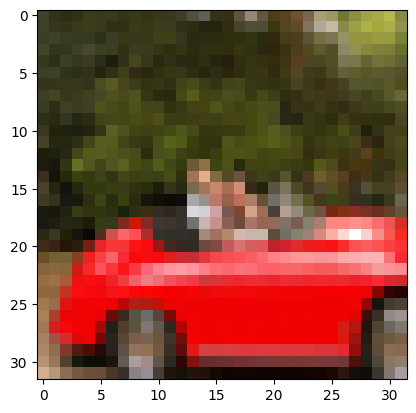

type(img_t_normalized) --> <class 'torch.Tensor'>
img_t_normalized.shape --> torch.Size([3, 32, 32])
img_t_normalized.dtype --> torch.float32


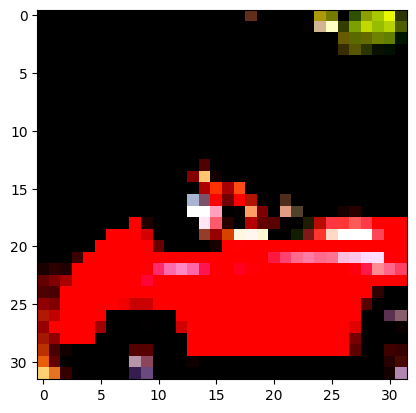

In [8]:
img, label = cifar10[99]
print('img -->',img)
print('label -->',label)
print('class_names[label] -->',class_names[label])
plt.imshow(img)
plt.show()

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)

normalize = transforms.Normalize(tuple_mean, tuple_std)
img_t_normalized = normalize(img_t)
print('type(img_t_normalized) -->',type(img_t_normalized))
print('img_t_normalized.shape -->',img_t_normalized.shape)
print('img_t_normalized.dtype -->',img_t_normalized.dtype)
plt.imshow(img_t_normalized.permute(1, 2, 0))  # Changes the order of the axes from C × H × W to H × W × C
plt.show()

## Compose

**transforms.Compose** composes several transforms together. It can handle normalization and data augmentation transparently, directly in the data loader.

In [9]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),   # mean
                             (0.2470, 0.2435, 0.2616))   # std
    ]))

transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

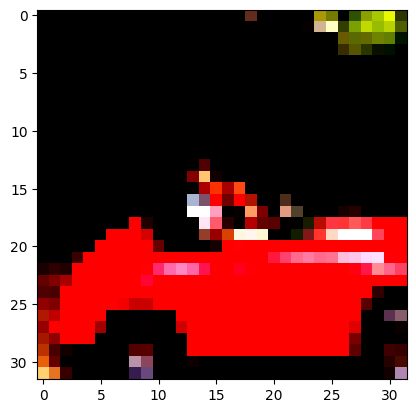

In [10]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()